In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
import math
import os

In [111]:
df = pd.read_csv("data/df_pp.csv")

In [112]:
n_clusters = 4

num_cols = df.select_dtypes(include="number").columns
scaler = StandardScaler()       
scaler.fit(df[num_cols])         
X_scaled = scaler.transform(df[num_cols])


X_scaled_T = X_scaled.T

# Rodar fuzzy c-means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled_T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None
)

labels = u.argmax(axis=0)
df["cluster_fuzzy"] = labels

for idx in range(n_clusters):
    df[f"pertinencia_cluster_{idx}"] = u[idx]

df.to_csv(f"data/df_agrupamentofuzzy_{n_clusters}.csv", index=False)
print(f"Arquivo salvo")

Arquivo salvo


In [113]:
caminho = f"data/df_agrupamentofuzzy_{n_clusters}.csv"
os.makedirs("results", exist_ok=True)
df = pd.read_csv(caminho, engine="pyarrow")

# (resto do código igual)
plt.figure(figsize=(8, 6))
plt.scatter(
    df['TIM_THROU_USER_PDCP_DL (Kbps)'],
    df['TIM_PRB_UTIL_MEAN_DL (%)'],
    c=df['cluster_fuzzy'],
    cmap='viridis',
    s=10
)
plt.title(f'Fuzzy C Means Throughput vs PRB util - Clusters: {n_clusters}')
plt.xlabel('Throughput DL (Kbps)')
plt.ylabel('PRB Util Mean DL (%)')

nome_saida = os.path.join("results", f"df_agrupamentofuzzy_{n_clusters}.png")
plt.savefig(nome_saida, dpi=300, bbox_inches="tight")
plt.close()

print(f"✅ Gráfico salvo em {nome_saida}")


✅ Gráfico salvo em results\df_agrupamentofuzzy_4.png


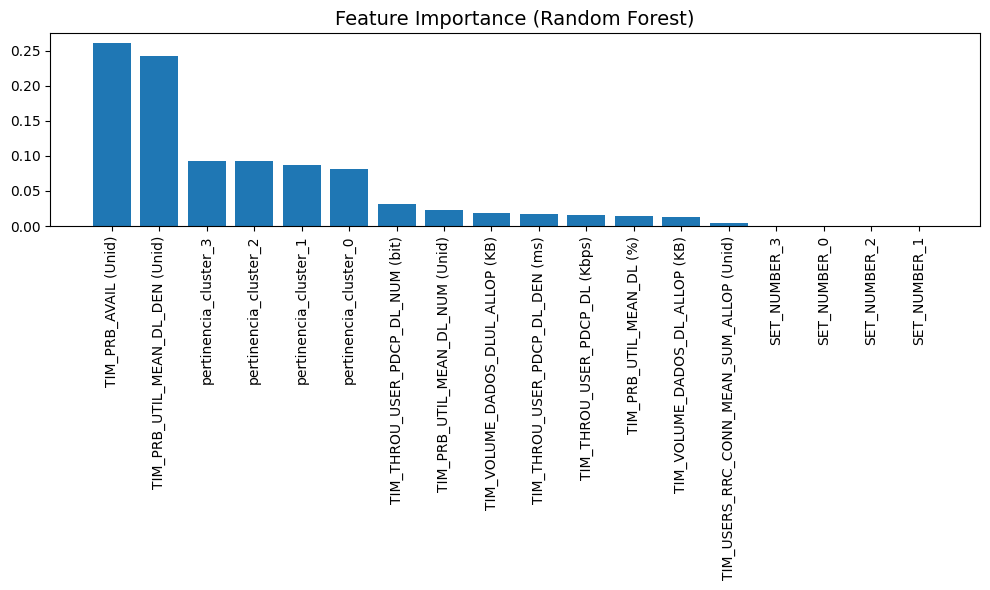

In [114]:
from sklearn.ensemble import RandomForestClassifier

# Separar features numéricas e target
num_cols = df.select_dtypes(include="number").columns.drop("cluster_fuzzy")
X = df[num_cols]
y = df["cluster_fuzzy"]

# Treinar Random Forest para extrair importâncias
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

# Importâncias das features
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotar gráfico
plt.figure(figsize=(10, 6))
plt.bar(range(len(num_cols)), importances[indices], align="center")
plt.xticks(range(len(num_cols)), num_cols[indices], rotation=90)
plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.tight_layout()
plt.show()

